# Capstone project

on this project I will create a model that returns a face alignment and for that I will use the MUCT data set
and with no longer due lets dive into this dataset and understand it before starting to work with it

In [1]:
#to work with the dataset i created a some scripts that i going to make the task easier
import DataGen

Using TensorFlow backend.


and lets import some other useful tools

In [2]:
from os import listdir
from os.path import isfile, join 
import random
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np

%matplotlib inline
%load_ext autoreload 
plt.rcParams["figure.figsize"] = (12,12)

this function will decompress the dataset and split it into 2 parts one for training and on for test.
the splitting is done this way so we can make sure that we don't have a same person on both sets

In [3]:
DataGen.decompress_dataset()

data already decompressed


In [4]:

# here we create a list with all files in the test set
test_files = []
train_files = []
for name in ['a', 'b', 'c', 'd', 'e']:
    test_path = "./decompressed_dataset/"+name+"_test/jpg"
    train_path = "./decompressed_dataset/"+name+"/jpg"
    test_files = test_files + [join(test_path, f) for f in listdir(test_path) if isfile(join(test_path, f))]
    train_files = train_files + [join(train_path, f) for f in listdir(train_path) if isfile(join(train_path, f))]


In [5]:
print("total of {} test files".format(len(test_files)))
print("total of {} training files".format(len(train_files)))

total of 1245 test files
total of 2510 training files


lets analyze one image 

In [6]:

image_path = random.choice(test_files)
image = cv2.imread(image_path)
print("the images are tensor of shape {}".format(image.shape))

the images are tensor of shape (640, 480, 3)


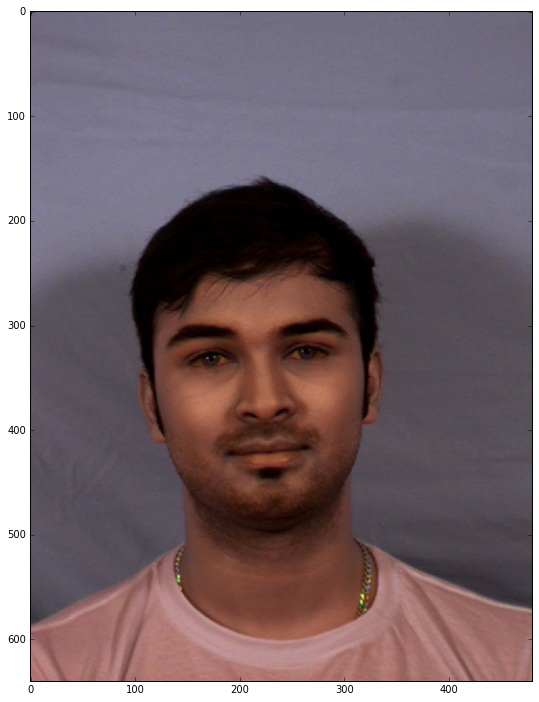

In [7]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

for the labels the the MUCT dataset gives us 4 different formats but we will be using the CSV format compatible with OpenCV


In [8]:
labels = DataGen.load_labels()
image_name = image_path.split("/")[-1].split(".")[0]
label = labels.loc[labels['name'] == image_name].values.tolist()[0][2:]
print("the labels format")
print(labels.head())
print("the chosen file label")
print(label)

the labels format
        name  tag  x00  y00    x01    y01    x02    y02  x03    y03  ...    \
0  i000qa-fn    0  201  348  201.0  381.0  202.0  408.0  209  435.0  ...     
1  i000qb-fn    0  162  357  157.0  387.0  160.0  418.0  167  446.0  ...     
2  i000qc-fn    0  212  352  203.0  380.0  200.0  407.0  211  439.0  ...     
3  i000qd-fn    0  157  316  155.0  348.0  154.0  373.0  159  407.0  ...     
4  i000qe-fn    0  201  373  200.0  408.0  203.0  433.0  213  463.0  ...     

     x71    y71    x72    y72    x73    y73    x74    y74    x75    y75  
0  235.5  348.5  338.0  333.5  324.0  335.5  326.0  342.5  340.0  340.5  
1  202.5  359.0  305.5  346.0  291.5  348.0  292.0  354.5  306.0  352.5  
2  257.5  355.0  344.5  343.5  334.0  345.0  335.0  351.0  345.5  349.5  
3  192.0  319.0  295.5  311.5  280.0  313.0  282.0  320.0  297.5  318.5  
4  237.0  377.5  335.5  366.5  322.0  369.0  324.5  375.0  338.0  372.5  

[5 rows x 154 columns]
the chosen file label
[117, 340, 120.0, 371.0

lets see how it looks on the image

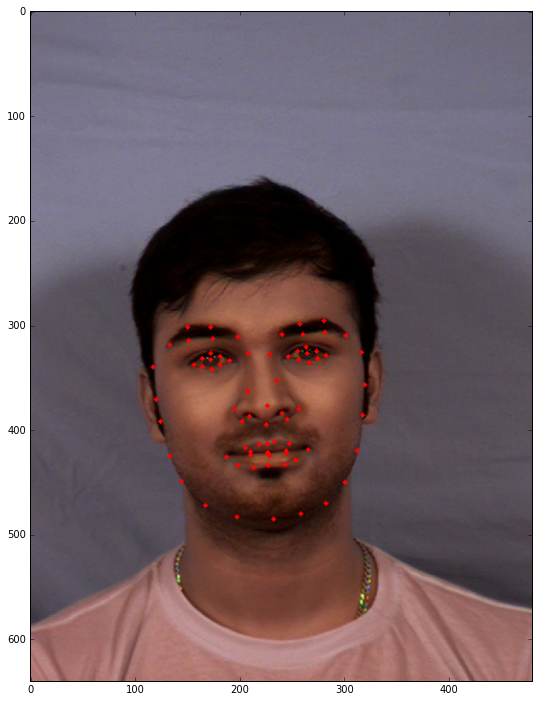

In [9]:
for i in range(0,151,2):
    cv2.circle(image, (int(label[i]),int(label[i+1]) ), 2, (255, 0, 0), -1)
plt.imshow(image)

for the training of the model we need to crop those images, for 2 reasons.
1 - the images are too large and will take a lot of resources to train
2 - most of the pre-trained models take smaller size and if we want to try transfer learning we will have to adapt it 


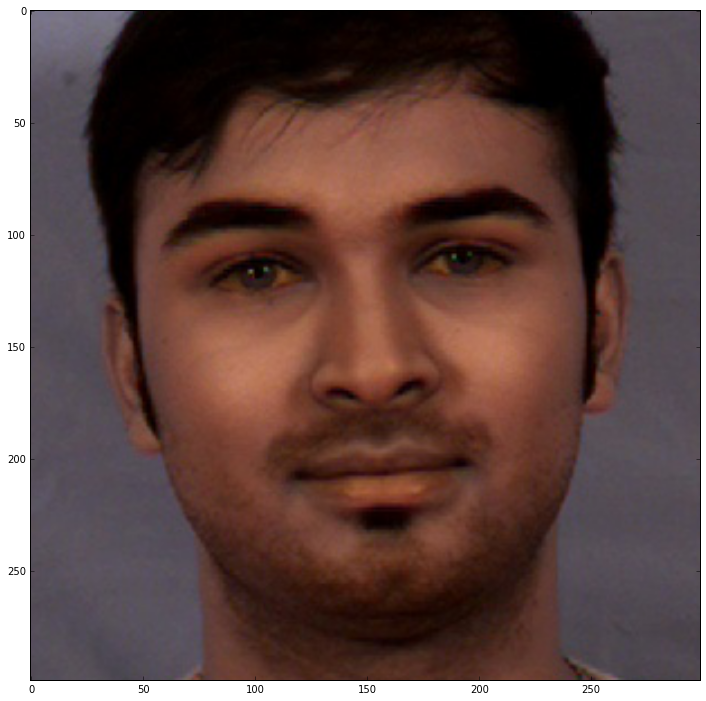

In [10]:
image2 = cv2.imread(image_path)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
croped_image, box = DataGen.crop_image(image2, 299)
croped_label = DataGen.replace_landmarks(box, label) 
plt.imshow(croped_image)


now we check if the new labels are good 

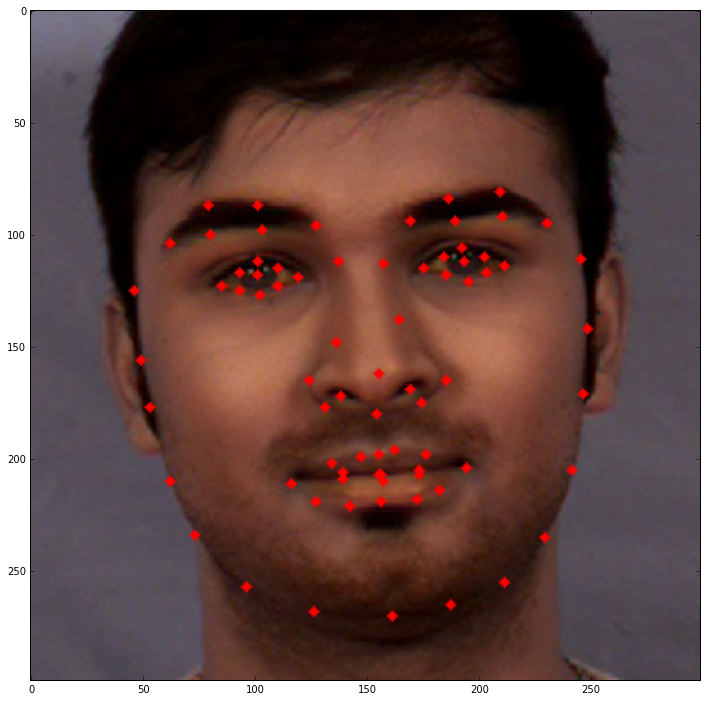

In [11]:
copy_of_croped_image = croped_image
for i in range(0,151,2):
    cv2.circle(copy_of_croped_image, (int(croped_label[i]),int(croped_label[i+1]) ), 2, (255, 0, 0), -1)
plt.imshow(copy_of_croped_image)

and here we will try a bit of data argumentation
by flipping the image 

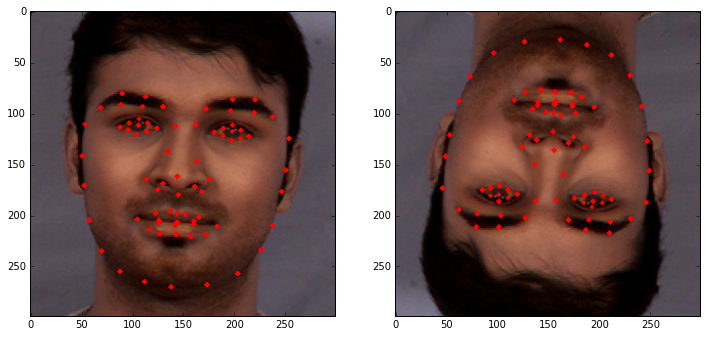

In [12]:
hflip = DataGen.flip_image(croped_image, croped_label, 1, 299, 299)
vflip = DataGen.flip_image(croped_image, croped_label, 0, 299, 299)
for i in range(0,151,2):
    cv2.circle(hflip[0], (int(hflip[1][i]),int(hflip[1][i+1]) ), 2, (255, 0, 0), -1)
    cv2.circle(vflip[0], (int(vflip[1][i]),int(vflip[1][i+1]) ), 2, (255, 0, 0), -1)
   
fig = plt.figure()
plt.subplot(221)
plt.imshow(hflip[0])
plt.subplot(222)
plt.imshow(vflip[0])
plt.show()

a data set with all the images an labels have being created and saved in a numpy file and cam be loaded like


In [13]:
dataset = np.load("299_dataset.npz")
print("total of testing images = {}".format(len(dataset['test_x'])))
print("total of training images = {}".format(len(dataset['train_x'])))

total of testing images = 3723
total of training images = 7497


all the models have being pre trained on a cloud server so here we will just load and see the results
for that we will use 9 images at random and see what it gives 

In [14]:
files = []

for x in range(0,9):
    files.append(random.choice(test_files))

def get_images(test_files):
    counter = 0
    test_images = []
    test_labels = []
    for file in test_files:
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_name = file.split("/")[-1].split(".")[0]
        label = labels.loc[labels['name'] == image_name].values.tolist()[0][2:]
        croped_image, box = DataGen.crop_image(image, 299)
        croped_label = DataGen.replace_landmarks(box, label) 
        if counter < 3:
            test_images.append(croped_image)
            test_labels.append(croped_label)
        elif counter > 2 and counter < 6:
            hflip = DataGen.flip_image(croped_image, croped_label, 1, 299, 299)
            test_images.append(hflip[0])
            test_labels.append(hflip[1])
        elif counter > 5:
            vflip = DataGen.flip_image(croped_image, croped_label, 0, 299, 299)
            test_images.append(vflip[0])
            test_labels.append(vflip[1])
        counter += 1
    return(test_images, test_labels)


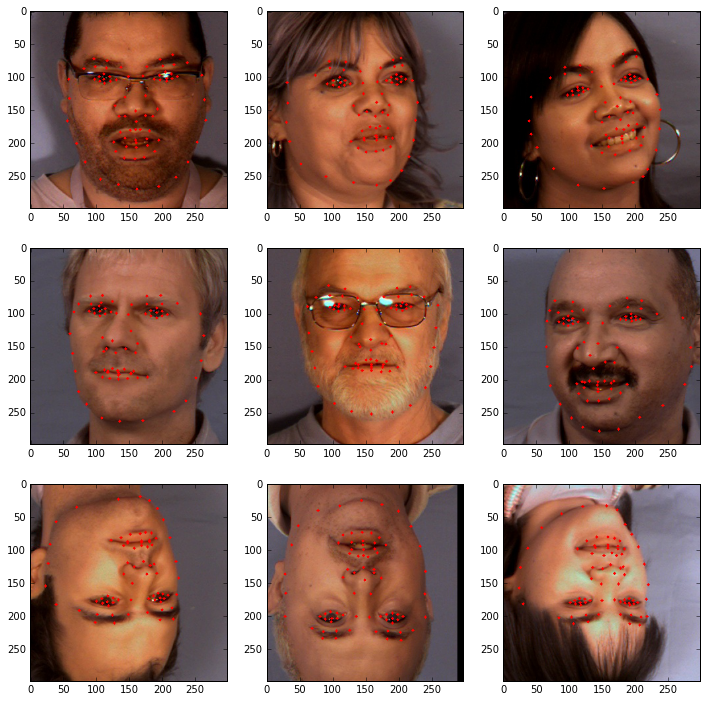

In [15]:
import copy

im = get_images(files)

def print_result(imgs, labels):
    pos = 331
    
    fig = plt.figure()
    for i in range(len(imgs)):
        for x in range(0,152,2):
            img = imgs[i]
            cv2.circle(img,(int(labels[i][x]),int(labels[i][x+1])), 2, (255, 0, 0), -1)
        plt.subplot(pos)
        plt.imshow(img)
        pos += 1
    plt.show()
            
            
print_result(im[0], im[1])       

lets load my own model first 

In [16]:
from keras.models import model_from_json
import numpy as np
from keras.layers import *
from keras.models import Sequential, Model
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras import optimizers, initializers
from keras.utils import plot_model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50

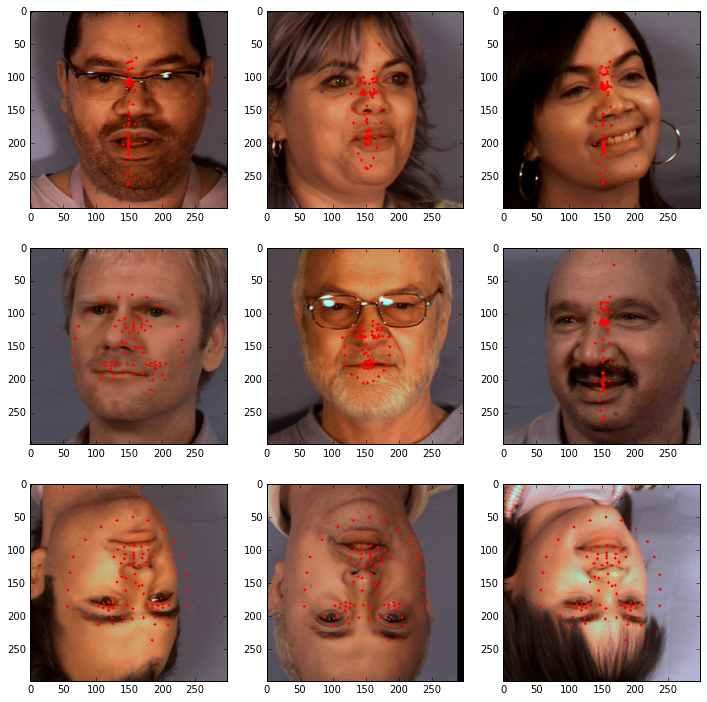

In [17]:
from keras.models import model_from_json

#load the model
mymodel = model_from_json(open('mymodel.json').read())
#and load the weights
mymodel.load_weights('best.mymodel.hdf5')
imgs = get_images(files)
preds =[(mymodel.predict(np.array([a]))*299).tolist()[0] for a in imgs[0]]

print_result(imgs[0], preds)



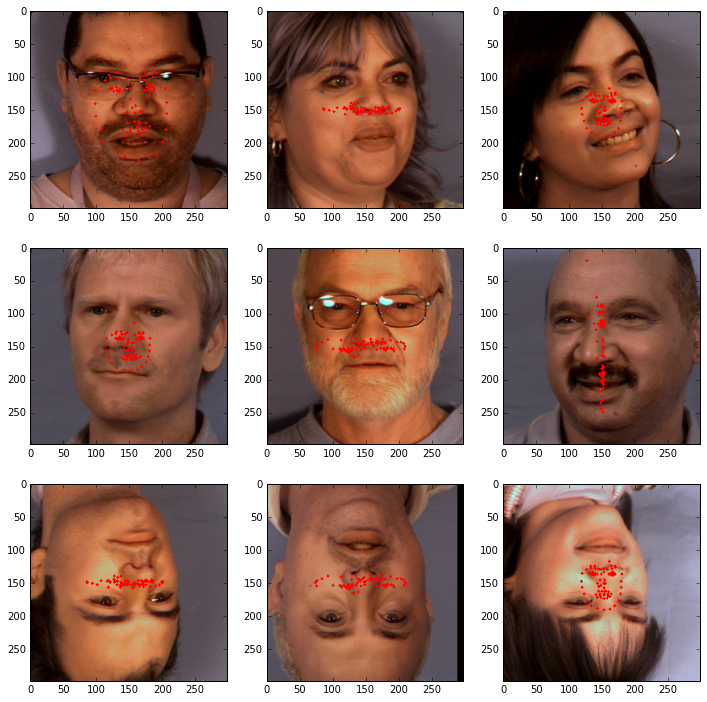

In [18]:
incep = InceptionV3(weights='imagenet')
bt =np.array([(incep.predict(np.array([a]))) for a in imgs[0]])



normal_input = Input(shape=bt.shape[1:])
squared_input = Input(shape=bt.shape[1:])
sin_input = Input(shape=bt.shape[1:])

normal_model = Dense(1000)(normal_input)
normal_model = BatchNormalization()(normal_model)
normal_model = Activation('relu')(normal_model)
normal_model = Dropout(0.3)(normal_model)


squared_model = Dense(1000)(squared_input)
squared_model = BatchNormalization()(squared_model)
squared_model = Activation('relu')(squared_model)
squared_model = Dropout(0.3)(squared_model)


sin_model = Dense(1000)(sin_input)
sin_model = BatchNormalization()(sin_model)
sin_model = Activation('relu')(sin_model)
sin_model = Dropout(0.3)(sin_model)



concat = concatenate([normal_model, squared_model, sin_model])


concat = Dense(1024)(concat)
concat = BatchNormalization()(concat)
concat = Activation('relu')(concat)
concat = Dropout(0.3)(concat)
concat = Dense(512)(concat)

output = Dense(152,activation='linear')(concat)

inceptionV3Bottleneck = Model(inputs=[normal_input, squared_input, sin_input],
                                  outputs=[output])

inceptionV3Bottleneck.compile(loss='mse',
                                  optimizer='nadam',
                                  metrics=['acc'])

inceptionV3Bottleneck.load_weights('best.inceptionBottleneck.hdf5')



imgs = get_images(files)

inputs_sin = np.sin(bt)
inputs_squared = bt**2

preds =[(inceptionV3Bottleneck.predict([np.array([a]),
                                        np.array([b]),
                                        np.array([c])])*299).tolist()[0][0] for a, b , c  in zip(bt,inputs_squared,inputs_sin)]

     
print_result(imgs[0],preds )

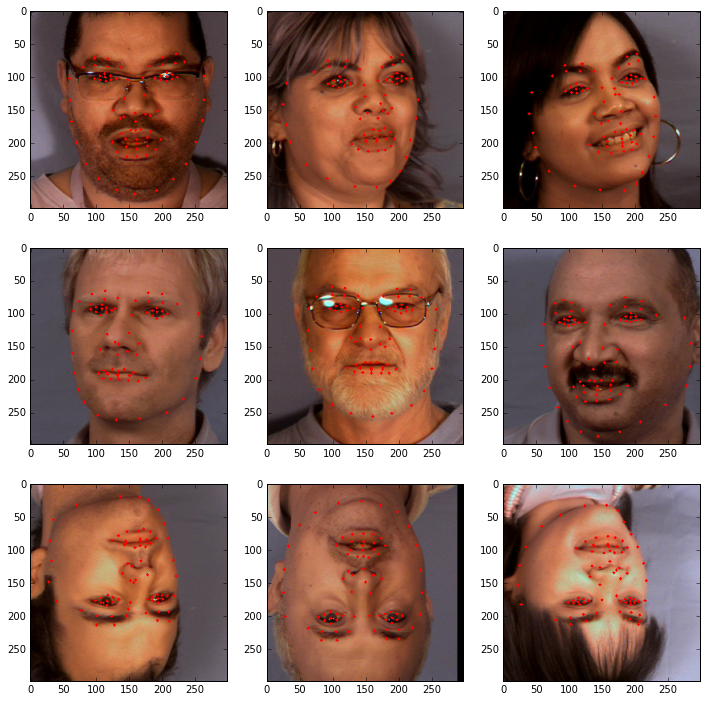

In [19]:


base_model = InceptionV3(weights='imagenet',
                             input_shape=(299,299,3),
                             include_top=False)



inputs = base_model.output
model = GlobalAveragePooling2D()(inputs)
output = Dense(152,activation='linear')(model)


fm = Model(base_model.input, outputs=output)

fm.compile(loss='mse', optimizer="adam" ,metrics=['acc'])

#and load the weights
fm.load_weights('best.inception249layers.hdf5')


imgs = get_images(files)
preds =[(fm.predict(np.array([a]))*299).tolist()[0] for a in imgs[0]]

print_result(imgs[0], preds)

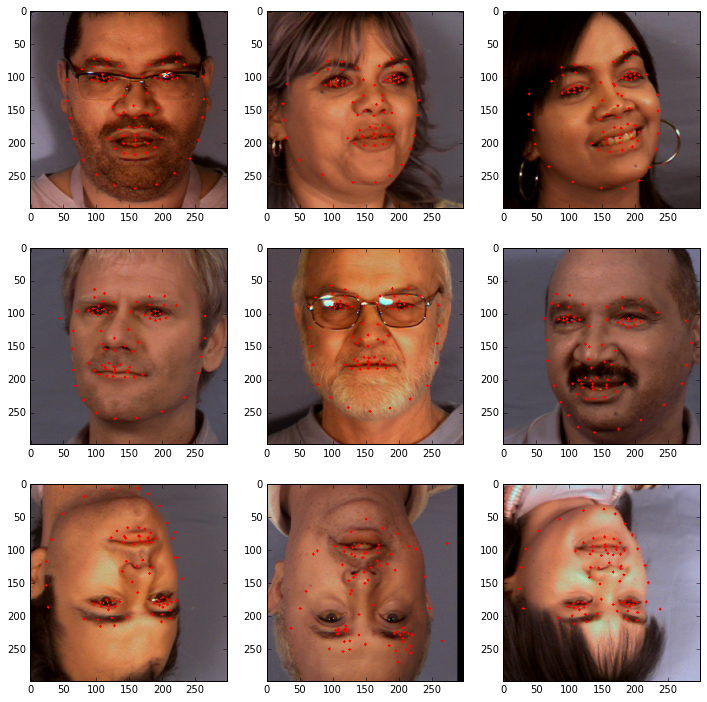

In [20]:
fm.load_weights('best.inception197layers.hdf5')


imgs = get_images(files)
preds =[(fm.predict(np.array([a]))*299).tolist()[0] for a in imgs[0]]

print_result(imgs[0], preds)

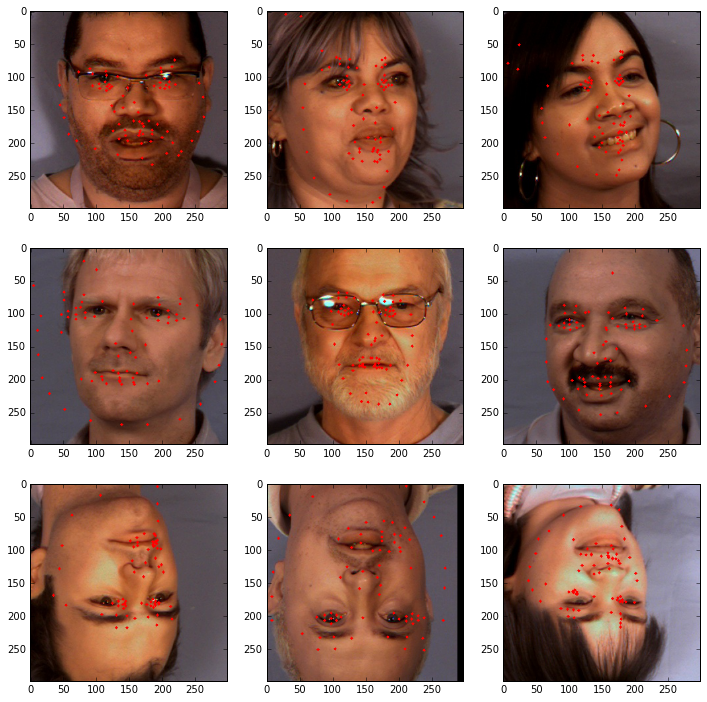

In [21]:
base_model = ResNet50(weights='imagenet',
                        input_shape=(299,299,3),
                        include_top=False)



inputs = base_model.output
model = GlobalAveragePooling2D()(inputs)
output = Dense(152,activation='linear')(model)


fm = Model(base_model.input, outputs=output)

   
fm.compile(loss='mse', optimizer="adam" ,metrics=['acc'])

fm.load_weights('best.resnet173layers.hdf5')

imgs = get_images(files)
preds =[(fm.predict(np.array([a]))*299).tolist()[0] for a in imgs[0]]

print_result(imgs[0], preds)


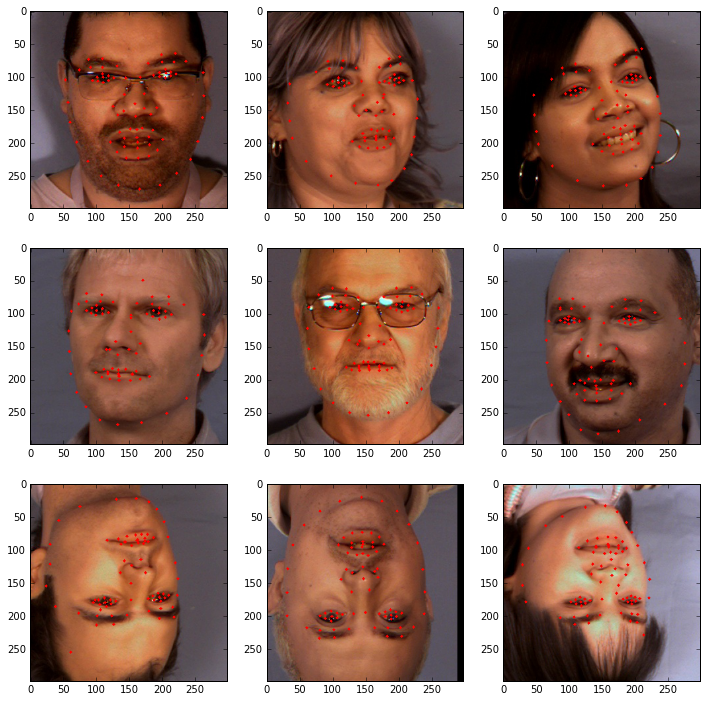

In [22]:
fm.load_weights('best.resnet129layers.hdf5')

imgs = get_images(files)
preds =[(fm.predict(np.array([a]))*299).tolist()[0] for a in imgs[0]]

print_result(imgs[0], preds)

In [23]:
gg

NameError: name 'gg' is not defined